SETUP AND INSTALLATION


In [2]:
!pip install -q matplotlib seaborn scikit-learn pandas numpy Pillow tqdm

In [3]:
import os
import sys
import time
import json
import copy
import zipfile
import requests
import warnings
from datetime import datetime
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.models import densenet201, mobilenet_v2
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

# Sklearn imports
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
print("✅ All packages imported successfully!")


✅ All packages imported successfully!


In [1]:
# Check GPU availability
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("WARNING: No GPU detected! This notebook is optimized for T4 GPU.")

CUDA Available: True
GPU Device: Tesla T4
CUDA Version: 12.6


GOOGLE DRIVE SETUP


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Set your dataset path in Google Drive
# Upload your dataset to Google Drive and update this path
DRIVE_DATASET_PATH = "/content/drive/MyDrive/dataset-resized"  # Update

print(f"Looking for dataset at: {DRIVE_DATASET_PATH}")
if os.path.exists(DRIVE_DATASET_PATH):
    print("✅ Dataset found in Google Drive!")
    # List contents to verify structure
    contents = os.listdir(DRIVE_DATASET_PATH)
    print(f"Dataset contents: {contents}")
else:
    print("❌ Dataset not found! Please:")
    print("1. Upload your TrashNet dataset to Google Drive")
    print("2. Update DRIVE_DATASET_PATH variable above")
    print("3. Ensure the dataset has folders: cardboard, glass, metal, paper, plastic, trash")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking for dataset at: /content/drive/MyDrive/dataset-resized
✅ Dataset found in Google Drive!
Dataset contents: ['trash', 'paper', 'plastic', 'metal', 'glass', 'cardboard']


MODEL ARCHITECTURE - RWC-Net


In [5]:
class RWCNet(nn.Module):
    """
    RWC-Net: Hybrid DenseNet201 + MobileNetV2 model with auxiliary outputs
    Optimized for T4 GPU with efficient memory usage
    """

    def __init__(self, num_classes=6, pretrained=True, dropout_rate=0.5):
        super(RWCNet, self).__init__()

        self.num_classes = num_classes
        self.dropout_rate = dropout_rate

        # Load pretrained backbones
        print("Loading pretrained backbones...")
        self.densenet = densenet201(pretrained=pretrained)
        self.mobilenet = mobilenet_v2(pretrained=pretrained)

        # Extract feature extractors
        self.densenet_features = self.densenet.features
        self.mobilenet_features = self.mobilenet.features

        # Feature dimensions
        self.densenet_out_features = 1920
        self.mobilenet_out_features = 1280

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Auxiliary classifiers
        self.aux_classifier1 = self._make_auxiliary_classifier(
            self.densenet_out_features, num_classes
        )
        self.aux_classifier2 = self._make_auxiliary_classifier(
            self.mobilenet_out_features, num_classes
        )

        # Main classifier with feature fusion
        combined_features = self.densenet_out_features + self.mobilenet_out_features

        self.main_classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(combined_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.7),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )

        self._initialize_weights()
        print(f"✅ RWC-Net initialized with {self._count_parameters():,} parameters")

    def _make_auxiliary_classifier(self, input_features, num_classes):
        return nn.Sequential(
            nn.Dropout(self.dropout_rate),
            nn.Linear(input_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_rate * 0.5),
            nn.Linear(256, num_classes)
        )

    def _initialize_weights(self):
        for module in [self.aux_classifier1, self.aux_classifier2, self.main_classifier]:
            for m in module.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def _count_parameters(self):
        return sum(p.numel() for p in self.parameters())

    def forward(self, x):
        # Extract features from both backbones
        densenet_feat = self.densenet_features(x)
        mobilenet_feat = self.mobilenet_features(x)

        # Global Average Pooling
        densenet_pooled = self.gap(densenet_feat).view(densenet_feat.size(0), -1)
        mobilenet_pooled = self.gap(mobilenet_feat).view(mobilenet_feat.size(0), -1)

        # Auxiliary outputs
        aux1 = self.aux_classifier1(densenet_pooled)
        aux2 = self.aux_classifier2(mobilenet_pooled)

        # Feature fusion
        combined_features = torch.cat([densenet_pooled, mobilenet_pooled], dim=1)

        # Main classification output
        main_output = self.main_classifier(combined_features)

        return main_output, aux1, aux2

    def forward_features(self, x):
        """Extract features for analysis"""
        densenet_feat = self.densenet_features(x)
        mobilenet_feat = self.mobilenet_features(x)

        densenet_pooled = self.gap(densenet_feat).view(densenet_feat.size(0), -1)
        mobilenet_pooled = self.gap(mobilenet_feat).view(mobilenet_feat.size(0), -1)

        combined_features = torch.cat([densenet_pooled, mobilenet_pooled], dim=1)

        return densenet_pooled, mobilenet_pooled, combined_features


LOSS FUNCTION


In [6]:
class RWCNetLoss(nn.Module):
    """Custom loss function with auxiliary loss weighting"""

    def __init__(self, aux1_weight=0.5, aux2_weight=0.25, class_weights=None):
        super(RWCNetLoss, self).__init__()
        self.aux1_weight = aux1_weight
        self.aux2_weight = aux2_weight
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, outputs, targets):
        main_output, aux1_output, aux2_output = outputs

        main_loss = self.criterion(main_output, targets)
        aux1_loss = self.criterion(aux1_output, targets)
        aux2_loss = self.criterion(aux2_output, targets)

        total_loss = main_loss + self.aux1_weight * aux1_loss + self.aux2_weight * aux2_loss

        return {
            'total_loss': total_loss,
            'main_loss': main_loss,
            'aux1_loss': aux1_loss,
            'aux2_loss': aux2_loss
        }

# DATASET HANDLING
class TrashNetDataset(Dataset):
    """TrashNet Dataset with optimized loading for Colab"""

    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split

        # Class names
        self.classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}

        # Load samples
        self.samples = []
        self.class_counts = {cls: 0 for cls in self.classes}
        self._load_samples()

    def _load_samples(self):
        print(f"Loading {self.split} samples...")

        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"⚠️ Warning: Class directory '{class_name}' not found!")
                continue

            # Get image files
            image_files = [f for f in os.listdir(class_dir)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            for img_name in image_files:
                img_path = os.path.join(class_dir, img_name)
                # Quick validation - just check if file exists and is not empty
                if os.path.exists(img_path) and os.path.getsize(img_path) > 0:
                    self.samples.append((img_path, self.class_to_idx[class_name]))
                    self.class_counts[class_name] += 1

        print(f"✅ Loaded {len(self.samples)} samples for {self.split}")
        self._print_distribution()

    def _print_distribution(self):
        print(f"\n{self.split.capitalize()} class distribution:")
        for class_name, count in self.class_counts.items():
            percentage = (count / len(self.samples)) * 100 if len(self.samples) > 0 else 0
            print(f"  {class_name:>10}: {count:>4} ({percentage:>5.1f}%)")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return blank image as fallback
            blank_image = Image.new('RGB', (224, 224), color='white')
            if self.transform:
                blank_image = self.transform(blank_image)
            return blank_image, label

    def get_class_weights(self):
        """Calculate balanced class weights"""
        total_samples = sum(self.class_counts.values())
        weights = []

        for class_name in self.classes:
            if self.class_counts[class_name] > 0:
                weight = total_samples / (len(self.classes) * self.class_counts[class_name])
                weights.append(weight)
            else:
                weights.append(1.0)

        return torch.FloatTensor(weights)

DATA TRANSFORMS AND LOADERS


In [7]:
class DataTransforms:
    """Data augmentation and preprocessing transforms optimized for T4"""

    @staticmethod
    def get_train_transforms(input_size=224):
        return transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),  # Reduced for faster training
            transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    @staticmethod
    def get_val_transforms(input_size=224):
        return transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

def create_data_loaders(dataset_path, batch_size=32, val_split=0.2, test_split=0.1, num_workers=2):
    """Create optimized data loaders for Colab T4"""

    # Get transforms
    train_transform = DataTransforms.get_train_transforms()
    val_transform = DataTransforms.get_val_transforms()

    # Load full dataset
    full_dataset = TrashNetDataset(dataset_path, transform=None, split='full')
    class_weights = full_dataset.get_class_weights()

    # Stratified splitting
    labels = [sample[1] for sample in full_dataset.samples]
    indices = list(range(len(full_dataset.samples)))

    # Split data
    train_val_indices, test_indices = train_test_split(
        indices, test_size=test_split, stratify=labels, random_state=42
    )

    train_val_labels = [labels[i] for i in train_val_indices]
    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=val_split/(1-test_split),
        stratify=train_val_labels, random_state=42
    )

    # Create subset datasets
    class TrashNetSubset(Dataset):
        def __init__(self, dataset, indices, transform):
            self.dataset = dataset
            self.indices = indices
            self.transform = transform

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            original_idx = self.indices[idx]
            img_path, label = self.dataset.samples[original_idx]

            try:
                image = Image.open(img_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                return image, label
            except:
                blank_image = Image.new('RGB', (224, 224), color='white')
                if self.transform:
                    blank_image = self.transform(blank_image)
                return blank_image, label

    train_dataset = TrashNetSubset(full_dataset, train_indices, train_transform)
    val_dataset = TrashNetSubset(full_dataset, val_indices, val_transform)
    test_dataset = TrashNetSubset(full_dataset, test_indices, val_transform)

    # Create data loaders (optimized for T4)
    pin_memory = torch.cuda.is_available()

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=pin_memory, drop_last=True
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory
    )

    print(f"\n📊 Data Loader Summary:")
    print(f"  Training samples:   {len(train_dataset):>6}")
    print(f"  Validation samples: {len(val_dataset):>6}")
    print(f"  Test samples:       {len(test_dataset):>6}")
    print(f"  Batch size:         {batch_size:>6}")

    return train_loader, val_loader, test_loader, class_weights



In [8]:
# TRAINING CONFIGURATION AND TRAINER

class TrainingConfig:
    """Training configuration optimized for T4 GPU"""
    def __init__(self):
        # Model parameters
        self.num_classes = 6
        self.pretrained = True
        self.dropout_rate = 0.5

        # Training parameters (T4 optimized)
        self.batch_size = 32  # Optimal for T4
        self.num_epochs = 30
        self.learning_rate = 1e-4
        self.weight_decay = 1e-4

        # Loss parameters
        self.aux1_weight = 0.5
        self.aux2_weight = 0.25
        self.use_class_weights = True

        # Optimization
        self.optimizer_type = 'adam'
        self.scheduler_type = 'step'
        self.step_size = 10
        self.gamma = 0.5

        # Early stopping
        self.patience = 8
        self.min_delta = 1e-4

        # Data parameters
        self.val_split = 0.2
        self.test_split = 0.1
        self.num_workers = 2  # Optimal for Colab

        # Device
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Logging
        self.print_freq = 20

class Trainer:
    """Optimized trainer for T4 GPU"""

    def __init__(self, config):
        self.config = config
        self.device = torch.device(config.device)

        # Model components
        self.model = None
        self.criterion = None
        self.optimizer = None
        self.scheduler = None

        # Training history
        self.history = {
            'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [],
            'train_main_loss': [], 'train_aux1_loss': [], 'train_aux2_loss': [],
            'learning_rates': []
        }

        # Best model tracking
        self.best_val_acc = 0.0
        self.best_model_state = None
        self.patience_counter = 0

    def setup_model(self, class_weights=None):
        """Initialize model, loss, and optimizer"""
        print("Setting up model...")

        # Create model
        self.model = RWCNet(
            num_classes=self.config.num_classes,
            pretrained=self.config.pretrained,
            dropout_rate=self.config.dropout_rate
        ).to(self.device)

        # Enable mixed precision training for T4
        self.scaler = torch.cuda.amp.GradScaler() if self.device.type == 'cuda' else None

        # Create loss function
        self.criterion = RWCNetLoss(
            aux1_weight=self.config.aux1_weight,
            aux2_weight=self.config.aux2_weight,
            class_weights=class_weights.to(self.device) if class_weights is not None else None
        )

        # Create optimizer
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay
        )

        # Create scheduler
        self.scheduler = StepLR(
            self.optimizer,
            step_size=self.config.step_size,
            gamma=self.config.gamma
        )

        print(f"✅ Model setup complete on {self.device}")

    def train_epoch(self, train_loader):
        """Train for one epoch with mixed precision"""
        self.model.train()

        running_loss = 0.0
        running_main_loss = 0.0
        running_aux1_loss = 0.0
        running_aux2_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc='Training', leave=False)

        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(self.device, non_blocking=True), targets.to(self.device, non_blocking=True)

            self.optimizer.zero_grad()

            # Mixed precision forward pass
            if self.scaler:
                with torch.cuda.amp.autocast():
                    main_output, aux1_output, aux2_output = self.model(inputs)
                    outputs = (main_output, aux1_output, aux2_output)
                    losses = self.criterion(outputs, targets)
                    total_loss = losses['total_loss']

                # Mixed precision backward pass
                self.scaler.scale(total_loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                main_output, aux1_output, aux2_output = self.model(inputs)
                outputs = (main_output, aux1_output, aux2_output)
                losses = self.criterion(outputs, targets)
                total_loss = losses['total_loss']

                total_loss.backward()
                self.optimizer.step()

            # Statistics
            running_loss += total_loss.item()
            running_main_loss += losses['main_loss'].item()
            running_aux1_loss += losses['aux1_loss'].item()
            running_aux2_loss += losses['aux2_loss'].item()

            # Calculate accuracy
            _, predicted = torch.max(main_output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{total_loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

        return {
            'loss': running_loss / len(train_loader),
            'main_loss': running_main_loss / len(train_loader),
            'aux1_loss': running_aux1_loss / len(train_loader),
            'aux2_loss': running_aux2_loss / len(train_loader),
            'accuracy': 100. * correct / total
        }

    def validate_epoch(self, val_loader):
        """Validate for one epoch"""
        self.model.eval()

        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc='Validating', leave=False):
                inputs, targets = inputs.to(self.device, non_blocking=True), targets.to(self.device, non_blocking=True)

                if self.scaler:
                    with torch.cuda.amp.autocast():
                        main_output, aux1_output, aux2_output = self.model(inputs)
                        outputs = (main_output, aux1_output, aux2_output)
                        losses = self.criterion(outputs, targets)
                        total_loss = losses['total_loss']
                else:
                    main_output, aux1_output, aux2_output = self.model(inputs)
                    outputs = (main_output, aux1_output, aux2_output)
                    losses = self.criterion(outputs, targets)
                    total_loss = losses['total_loss']

                running_loss += total_loss.item()

                _, predicted = torch.max(main_output.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        return {
            'loss': running_loss / len(val_loader),
            'accuracy': 100. * correct / total
        }

    def train(self, train_loader, val_loader):
        """Main training loop"""
        print(f"\n🚀 Starting Training on {self.device}")
        print("="*50)

        start_time = time.time()

        for epoch in range(self.config.num_epochs):
            epoch_start = time.time()

            print(f'\n📅 Epoch {epoch+1}/{self.config.num_epochs}')

            # Training phase
            train_metrics = self.train_epoch(train_loader)

            # Validation phase
            val_metrics = self.validate_epoch(val_loader)

            # Update learning rate
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']

            # Update history
            self.history['train_loss'].append(train_metrics['loss'])
            self.history['val_loss'].append(val_metrics['loss'])
            self.history['train_acc'].append(train_metrics['accuracy'])
            self.history['val_acc'].append(val_metrics['accuracy'])
            self.history['train_main_loss'].append(train_metrics['main_loss'])
            self.history['train_aux1_loss'].append(train_metrics['aux1_loss'])
            self.history['train_aux2_loss'].append(train_metrics['aux2_loss'])
            self.history['learning_rates'].append(current_lr)

            # Print results
            epoch_time = time.time() - epoch_start
            print(f'📈 Train: Loss={train_metrics["loss"]:.4f}, Acc={train_metrics["accuracy"]:.2f}%')
            print(f'📉 Val:   Loss={val_metrics["loss"]:.4f}, Acc={val_metrics["accuracy"]:.2f}%')
            print(f'⏰ Time: {epoch_time:.1f}s, LR: {current_lr:.2e}')

            # Check for improvement
            if val_metrics['accuracy'] > self.best_val_acc + self.config.min_delta:
                self.best_val_acc = val_metrics['accuracy']
                self.best_model_state = copy.deepcopy(self.model.state_dict())
                self.patience_counter = 0
                print(f'🎉 New best model! Val Acc: {self.best_val_acc:.2f}%')
            else:
                self.patience_counter += 1

            # Early stopping
            if self.patience_counter >= self.config.patience:
                print(f'⏹️ Early stopping triggered after {epoch+1} epochs')
                break

        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print(f'✅ Loaded best model with validation accuracy: {self.best_val_acc:.2f}%')

        total_time = time.time() - start_time
        print(f'\n🏁 Training completed in {total_time/60:.2f} minutes')

        return self.model

    def plot_training_history(self, figsize=(15, 10)):
        """Plot comprehensive training history"""
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # Loss plot
        axes[0, 0].plot(self.history['train_loss'], label='Training Loss', color='blue', linewidth=2)
        axes[0, 0].plot(self.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
        axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Accuracy plot
        axes[0, 1].plot(self.history['train_acc'], label='Training Accuracy', color='blue', linewidth=2)
        axes[0, 1].plot(self.history['val_acc'], label='Validation Accuracy', color='red', linewidth=2)
        axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Loss components
        axes[1, 0].plot(self.history['train_main_loss'], label='Main Loss', color='blue', linewidth=2)
        axes[1, 0].plot(self.history['train_aux1_loss'], label='Aux1 Loss', color='green', linewidth=2)
        axes[1, 0].plot(self.history['train_aux2_loss'], label='Aux2 Loss', color='orange', linewidth=2)
        axes[1, 0].set_title('Training Loss Components', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Learning rate plot
        axes[1, 1].plot(self.history['learning_rates'], color='purple', linewidth=2)
        axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

MODEL EVALUATION


In [9]:
class ModelEvaluator:
    """Comprehensive model evaluation with T4 optimization"""

    def __init__(self, model, device='cuda'):
        self.model = model.to(device)
        self.device = torch.device(device)
        self.class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
        self.num_classes = len(self.class_names)

        # Results storage
        self.results = {
            'predictions': [],
            'true_labels': [],
            'probabilities': [],
            'metrics': {}
        }

    def evaluate_dataset(self, dataloader):
        """Evaluate model on dataset with T4 optimization"""
        self.model.eval()

        all_predictions = []
        all_true_labels = []
        all_probabilities = []

        print("🔍 Evaluating model...")

        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader, desc='Evaluating')):
                inputs, labels = inputs.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)

                # Forward pass with mixed precision
                with torch.cuda.amp.autocast():
                    main_output, aux1_output, aux2_output = self.model(inputs)

                # Get predictions and probabilities
                probabilities = F.softmax(main_output, dim=1)
                _, predicted = torch.max(main_output, 1)

                # Store results
                all_predictions.extend(predicted.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

        # Store results
        self.results['predictions'] = np.array(all_predictions)
        self.results['true_labels'] = np.array(all_true_labels)
        self.results['probabilities'] = np.array(all_probabilities)

        # Calculate metrics
        self._calculate_metrics()

        print("✅ Evaluation completed!")
        return self.results

    def _calculate_metrics(self):
        """Calculate comprehensive evaluation metrics"""
        y_true = self.results['true_labels']
        y_pred = self.results['predictions']
        y_prob = self.results['probabilities']

        # Basic metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
        precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
        recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        # Per-class metrics
        precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
        recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
        f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)

        # Store metrics
        self.results['metrics'] = {
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'precision_weighted': precision_weighted,
            'recall_macro': recall_macro,
            'recall_weighted': recall_weighted,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'precision_per_class': precision_per_class.tolist(),
            'recall_per_class': recall_per_class.tolist(),
            'f1_per_class': f1_per_class.tolist()
        }

        # Calculate ROC AUC
        try:
            y_true_bin = label_binarize(y_true, classes=list(range(self.num_classes)))
            roc_auc_per_class = []
            for i in range(self.num_classes):
                if len(np.unique(y_true_bin[:, i])) > 1:
                    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
                    roc_auc_per_class.append(auc(fpr, tpr))
                else:
                    roc_auc_per_class.append(0.0)

            self.results['metrics']['roc_auc_per_class'] = roc_auc_per_class
            self.results['metrics']['roc_auc_macro'] = np.mean(roc_auc_per_class)

        except Exception as e:
            print(f"⚠️ Could not calculate ROC AUC: {e}")
            self.results['metrics']['roc_auc_per_class'] = [0.0] * self.num_classes
            self.results['metrics']['roc_auc_macro'] = 0.0

    def print_metrics_summary(self):
        """Print comprehensive metrics summary"""
        metrics = self.results['metrics']

        print("\n" + "="*60)
        print("📊 MODEL EVALUATION METRICS")
        print("="*60)

        # Overall metrics
        print(f"{'Accuracy':<25}: {metrics['accuracy']:.4f}")
        print(f"{'Precision (Macro)':<25}: {metrics['precision_macro']:.4f}")
        print(f"{'Precision (Weighted)':<25}: {metrics['precision_weighted']:.4f}")
        print(f"{'Recall (Macro)':<25}: {metrics['recall_macro']:.4f}")
        print(f"{'Recall (Weighted)':<25}: {metrics['recall_weighted']:.4f}")
        print(f"{'F1-Score (Macro)':<25}: {metrics['f1_macro']:.4f}")
        print(f"{'F1-Score (Weighted)':<25}: {metrics['f1_weighted']:.4f}")
        print(f"{'ROC AUC (Macro)':<25}: {metrics['roc_auc_macro']:.4f}")

        print("\n" + "-"*60)
        print("📈 PER-CLASS METRICS")
        print("-"*60)
        print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'ROC AUC':<10}")
        print("-"*60)

        for i, class_name in enumerate(self.class_names):
            precision = metrics['precision_per_class'][i]
            recall = metrics['recall_per_class'][i]
            f1 = metrics['f1_per_class'][i]
            roc_auc = metrics['roc_auc_per_class'][i]

            print(f"{class_name:<12} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {roc_auc:<10.4f}")

        print("="*60)

    def plot_confusion_matrix(self, figsize=(10, 8)):
        """Plot confusion matrix"""
        cm = confusion_matrix(self.results['true_labels'], self.results['predictions'])

        plt.figure(figsize=figsize)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names, yticklabels=self.class_names,
                   cbar_kws={'label': 'Count'})
        plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.tight_layout()
        plt.show()

        # Print normalized confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        print("\n📋 Normalized Confusion Matrix:")
        print("-" * 50)
        df_cm = pd.DataFrame(cm_normalized,
                           index=[f'True_{cls}' for cls in self.class_names],
                           columns=[f'Pred_{cls}' for cls in self.class_names])
        print(df_cm.round(3).to_string())

    def plot_roc_curves(self, figsize=(12, 8)):
        """Plot ROC curves"""
        y_true = self.results['true_labels']
        y_prob = self.results['probabilities']

        y_true_bin = label_binarize(y_true, classes=list(range(self.num_classes)))

        plt.figure(figsize=figsize)
        colors = plt.cm.Set3(np.linspace(0, 1, self.num_classes))

        for i, color in enumerate(colors):
            if len(np.unique(y_true_bin[:, i])) > 1:
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, color=color, lw=2,
                        label=f'{self.class_names[i]} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves - Multi-Class Classification', fontsize=16, fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def analyze_misclassifications(self, dataloader, num_samples=12):
        """Analyze misclassified samples"""
        misclassified_indices = np.where(
            self.results['predictions'] != self.results['true_labels']
        )[0]

        if len(misclassified_indices) == 0:
            print("🎉 No misclassified samples found!")
            return

        print(f"🔍 Found {len(misclassified_indices)} misclassified samples")

        # Get sample of misclassified images
        sample_indices = np.random.choice(
            misclassified_indices,
            size=min(num_samples, len(misclassified_indices)),
            replace=False
        )

        # Extract images for visualization (this is simplified - in practice you'd need to track image indices)
        print(f"📈 Error Rate by Class:")
        for i, class_name in enumerate(self.class_names):
            class_mask = self.results['true_labels'] == i
            if np.sum(class_mask) > 0:
                class_errors = np.sum((self.results['true_labels'] == i) &
                                    (self.results['predictions'] != i))
                error_rate = class_errors / np.sum(class_mask)
                print(f"  {class_name:>10}: {error_rate:.3f} ({class_errors}/{np.sum(class_mask)})")

VISUALIZATION UTILITIES


In [10]:
def visualize_sample_predictions(model, dataloader, device, num_samples=12):
    """Visualize sample predictions with confidence scores"""
    model.eval()
    class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

    # Get a batch of samples
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    # Select samples
    indices = np.random.choice(len(images), size=min(num_samples, len(images)), replace=False)
    sample_images = images[indices]
    sample_labels = labels[indices]

    # Make predictions
    with torch.no_grad():
        sample_images = sample_images.to(device)
        with torch.cuda.amp.autocast():
            outputs, _, _ = model(sample_images)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        confidences = torch.max(probabilities, 1)[0]

    # Visualization
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    # Denormalization for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(min(num_samples, 12)):
        if i < len(sample_images):
            # Denormalize image
            img = sample_images[i].cpu()
            img_denorm = img * std + mean
            img_denorm = torch.clamp(img_denorm, 0, 1)

            # Plot image
            axes[i].imshow(img_denorm.permute(1, 2, 0))

            # Get labels and predictions
            true_label = class_names[sample_labels[i].item()]
            pred_label = class_names[predicted[i].item()]
            confidence = confidences[i].item()

            # Color coding: green if correct, red if wrong
            color = 'green' if sample_labels[i] == predicted[i] else 'red'

            axes[i].set_title(
                f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}',
                color=color, fontsize=10, fontweight='bold'
            )
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.suptitle('Sample Predictions with Confidence Scores', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_class_distribution(dataset_path):
    """Plot class distribution of the dataset"""
    class_counts = {}
    class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.exists(class_dir):
            count = len([f for f in os.listdir(class_dir)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
            class_counts[class_name] = count
        else:
            class_counts[class_name] = 0

    # Create bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values(),
                   color=plt.cm.Set3(np.arange(len(class_names))), alpha=0.8)

    plt.title('Dataset Class Distribution', fontsize=16, fontweight='bold')
    plt.xlabel('Waste Categories', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45)

    # Add count labels on bars
    for bar, count in zip(bars, class_counts.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                str(count), ha='center', va='bottom', fontweight='bold')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print statistics
    total_images = sum(class_counts.values())
    print(f"\n📊 Dataset Statistics:")
    print(f"{'Class':<12} {'Count':<8} {'Percentage'}")
    print("-" * 35)
    for class_name, count in class_counts.items():
        percentage = (count / total_images) * 100 if total_images > 0 else 0
        print(f"{class_name:<12} {count:<8} {percentage:>6.1f}%")
    print("-" * 35)
    print(f"{'Total':<12} {total_images:<8} {'100.0%'}")

MAIN EXECUTION


In [11]:
def run_complete_training():
    """🚀 MAIN FUNCTION - Run complete training pipeline"""

    print("🎯 RWC-Net: Recyclable Waste Classification Network")
    print("=" * 60)

    # Check dataset
    if not os.path.exists(DRIVE_DATASET_PATH):
        print("❌ Dataset not found! Please update DRIVE_DATASET_PATH")
        return None

    # Plot dataset distribution
    print("📊 Analyzing dataset distribution...")
    plot_class_distribution(DRIVE_DATASET_PATH)

    # Create configuration
    config = TrainingConfig()
    print(f"\n⚙️ Training Configuration:")
    print(f"  Device: {config.device}")
    print(f"  Batch Size: {config.batch_size}")
    print(f"  Learning Rate: {config.learning_rate}")
    print(f"  Epochs: {config.num_epochs}")
    print(f"  Mixed Precision: {torch.cuda.is_available()}")

    # Create data loaders
    print("\n📂 Creating data loaders...")
    train_loader, val_loader, test_loader, class_weights = create_data_loaders(
        DRIVE_DATASET_PATH,
        batch_size=config.batch_size,
        val_split=config.val_split,
        test_split=config.test_split,
        num_workers=config.num_workers
    )

    print(f"🏷️ Class weights: {class_weights.numpy().round(3)}")

    # Create trainer
    trainer = Trainer(config)
    trainer.setup_model(class_weights)

    # Train model
    print("\n🏃‍♂️ Starting training...")
    trained_model = trainer.train(train_loader, val_loader)

    # Plot training history
    print("\n📈 Training History:")
    trainer.plot_training_history()

    # Evaluate on test set
    print("\n🧪 Evaluating on test set...")
    evaluator = ModelEvaluator(trained_model, config.device)
    test_results = evaluator.evaluate_dataset(test_loader)

    # Print metrics
    evaluator.print_metrics_summary()

    # Plot evaluation results
    print("\n📊 Evaluation Visualizations:")
    evaluator.plot_confusion_matrix()
    evaluator.plot_roc_curves()

    # Analyze misclassifications
    evaluator.analyze_misclassifications(test_loader)

    # Visualize sample predictions
    print("\n🔍 Sample Predictions:")
    visualize_sample_predictions(trained_model, test_loader, config.device)

    # Save model
    print("\n💾 Saving trained model...")
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'config': config.__dict__,
        'class_names': ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
        'best_val_acc': trainer.best_val_acc,
        'test_metrics': test_results['metrics'],
        'training_history': trainer.history
    }, '/content/rwc_net_trained_model.pth')

    print("✅ Model saved to '/content/rwc_net_trained_model.pth'")

    # Final summary
    print(f"\n🎉 Training Complete!")
    print(f"📊 Final Results:")
    print(f"  Best Validation Accuracy: {trainer.best_val_acc:.2f}%")
    print(f"  Test Accuracy: {test_results['metrics']['accuracy']*100:.2f}%")
    print(f"  Test F1-Score (Macro): {test_results['metrics']['f1_macro']:.4f}")
    print(f"  Test ROC AUC (Macro): {test_results['metrics']['roc_auc_macro']:.4f}")

    return trained_model, trainer, evaluator

def run_quick_test():
    """🧪 Quick test with reduced parameters for fast execution"""

    print("🧪 Quick Test Mode - Reduced Parameters")
    print("=" * 50)

    # Quick config
    config = TrainingConfig()
    config.num_epochs = 5  # Reduced epochs
    config.batch_size = 16  # Smaller batch
    config.patience = 3

    print(f"⚙️ Quick Test Config: {config.num_epochs} epochs, batch size {config.batch_size}")

    # Create data loaders
    train_loader, val_loader, test_loader, class_weights = create_data_loaders(
        DRIVE_DATASET_PATH,
        batch_size=config.batch_size,
        num_workers=config.num_workers
    )

    # Train
    trainer = Trainer(config)
    trainer.setup_model(class_weights)
    trained_model = trainer.train(train_loader, val_loader)

    # Quick evaluation
    evaluator = ModelEvaluator(trained_model, config.device)
    test_results = evaluator.evaluate_dataset(test_loader)
    evaluator.print_metrics_summary()

    print(f"🧪 Quick test completed! Test Accuracy: {test_results['metrics']['accuracy']*100:.2f}%")

    return trained_model, trainer, evaluator

def predict_single_image(model, image_path, device='cuda'):
    """🔍 Predict single image"""
    class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    transform = DataTransforms.get_val_transforms()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            main_output, _, _ = model(image_tensor)
        probabilities = F.softmax(main_output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    # Get top-3 predictions
    top_probs, top_indices = torch.topk(probabilities[0], 3)

    print(f"🔍 Prediction Results:")
    print(f"  Predicted Class: {class_names[predicted_class]}")
    print(f"  Confidence: {confidence:.3f}")
    print(f"  Top 3 Predictions:")
    for i in range(3):
        print(f"    {i+1}. {class_names[top_indices[i]]}: {top_probs[i]:.3f}")

    # Display image with prediction
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f'Prediction: {class_names[predicted_class]} (Confidence: {confidence:.3f})',
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return {
        'predicted_class': class_names[predicted_class],
        'confidence': confidence,
        'all_probabilities': probabilities[0].cpu().numpy()
    }

In [14]:
print("  1. run_complete_training() - Full training pipeline")
print("  2. run_quick_test() - Quick test with reduced parameters")
print("  3. predict_single_image(model, path) - Predict single image")
print("  4. plot_class_distribution(path) - Analyze dataset")

  run_complete_training() - Full training pipeline


🚀MAIN EXECUTION FUNCTION


In [17]:
def main(mode='complete', dataset_path=None, quick_epochs=5):
    """
    🎯 Main execution function - Choose your training mode

    Args:
        mode (str): 'complete', 'quick', 'analyze', or 'demo'
        dataset_path (str): Path to dataset (uses DRIVE_DATASET_PATH if None)
        quick_epochs (int): Number of epochs for quick mode

    Returns:
        dict: Results containing model, trainer, and evaluator
    """

    # Use global dataset path if not provided
    if dataset_path is None:
        dataset_path = DRIVE_DATASET_PATH

    # Validate dataset path
    if not os.path.exists(dataset_path):
        print("❌ DATASET NOT FOUND!")
        print(f"   Looking for: {dataset_path}")
        print("   Please:")
        print("   1. Upload TrashNet dataset to Google Drive")
        print("   2. Update DRIVE_DATASET_PATH variable")
        print("   3. Ensure folders exist: cardboard, glass, metal, paper, plastic, trash")
        return None

    print("🎯 RWC-Net: Recyclable Waste Classification Network")
    print("=" * 70)
    print(f"📂 Dataset Path: {dataset_path}")
    print(f"🎮 Execution Mode: {mode.upper()}")
    print("=" * 70)

    results = {}

    # MODE 1: DATASET ANALYSIS ONLY
    if mode.lower() == 'analyze':
        print("📊 DATASET ANALYSIS MODE")
        print("-" * 40)

        # Analyze dataset distribution
        plot_class_distribution(dataset_path)

        # Create sample data loader to show some images
        _, val_loader, _, _ = create_data_loaders(
            dataset_path, batch_size=16, num_workers=2
        )

        print("🖼️ Sample Images from Dataset:")
        data_iter = iter(val_loader)
        images, labels = next(data_iter)
        class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

        # Show sample images
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.ravel()

        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

        for i in range(8):
            img = images[i]
            img_denorm = img * std + mean
            img_denorm = torch.clamp(img_denorm, 0, 1)

            axes[i].imshow(img_denorm.permute(1, 2, 0))
            axes[i].set_title(f'{class_names[labels[i]]}', fontsize=12, fontweight='bold')
            axes[i].axis('off')

        plt.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        results['mode'] = 'analyze'
        results['message'] = "Dataset analysis completed!"

    # MODE 2: QUICK TEST MODE
    elif mode.lower() == 'quick':
        print("🧪 QUICK TEST MODE")
        print("-" * 40)

        # Quick configuration
        config = TrainingConfig()
        config.num_epochs = quick_epochs
        config.batch_size = 16  # Smaller for quick test
        config.patience = 3
        config.learning_rate = 2e-4  # Slightly higher for quick convergence

        print(f"⚙️ Quick Config: {config.num_epochs} epochs, batch size {config.batch_size}")

        # Create data loaders
        train_loader, val_loader, test_loader, class_weights = create_data_loaders(
            dataset_path, batch_size=config.batch_size, num_workers=config.num_workers
        )

        # Setup and train
        trainer = Trainer(config)
        trainer.setup_model(class_weights)

        print("🏃‍♂️ Starting quick training...")
        trained_model = trainer.train(train_loader, val_loader)

        # Quick evaluation
        print("🧪 Quick evaluation...")
        evaluator = ModelEvaluator(trained_model, config.device)
        test_results = evaluator.evaluate_dataset(test_loader)

        # Show results
        evaluator.print_metrics_summary()
        trainer.plot_training_history()
        evaluator.plot_confusion_matrix()

        # Sample predictions
        print("🔍 Sample Predictions:")
        visualize_sample_predictions(trained_model, test_loader, config.device, num_samples=8)

        results = {
            'mode': 'quick',
            'model': trained_model,
            'trainer': trainer,
            'evaluator': evaluator,
            'test_accuracy': test_results['metrics']['accuracy'] * 100,
            'best_val_accuracy': trainer.best_val_acc,
            'message': f"Quick training completed! Test Accuracy: {test_results['metrics']['accuracy']*100:.2f}%"
        }

    # MODE 3: DEMO MODE (Minimal training for demonstration)
    elif mode.lower() == 'demo':
        print("🎮 DEMO MODE - Minimal Training")
        print("-" * 40)

        # Demo configuration - very fast
        config = TrainingConfig()
        config.num_epochs = 3
        config.batch_size = 8
        config.patience = 2
        config.learning_rate = 5e-4

        print(f"🎮 Demo Config: {config.num_epochs} epochs, batch size {config.batch_size}")
        print("⚠️  Note: This is for demonstration only - not for real training!")

        # Create smaller data subset for demo
        train_loader, val_loader, test_loader, class_weights = create_data_loaders(
            dataset_path, batch_size=config.batch_size,
            val_split=0.3, test_split=0.2,  # Larger splits for smaller dataset
            num_workers=1
        )

        # Setup and train
        trainer = Trainer(config)
        trainer.setup_model(class_weights)

        print("🎮 Starting demo training...")
        trained_model = trainer.train(train_loader, val_loader)

        # Demo evaluation
        print("🎮 Demo evaluation...")
        evaluator = ModelEvaluator(trained_model, config.device)
        test_results = evaluator.evaluate_dataset(test_loader)

        evaluator.print_metrics_summary()
        visualize_sample_predictions(trained_model, test_loader, config.device, num_samples=4)

        results = {
            'mode': 'demo',
            'model': trained_model,
            'trainer': trainer,
            'evaluator': evaluator,
            'message': "Demo completed - for real training use 'complete' mode!"
        }

    # MODE 4: COMPLETE TRAINING MODE (DEFAULT)
    else:  # mode == 'complete'
        print("🚀 COMPLETE TRAINING MODE")
        print("-" * 40)

        # Full configuration
        config = TrainingConfig()
        print(f"⚙️ Full Training Configuration:")
        print(f"  Device: {config.device}")
        print(f"  Batch Size: {config.batch_size}")
        print(f"  Learning Rate: {config.learning_rate}")
        print(f"  Max Epochs: {config.num_epochs}")
        print(f"  Mixed Precision: {torch.cuda.is_available()}")

        # Dataset analysis first
        print("\n📊 Analyzing dataset...")
        plot_class_distribution(dataset_path)

        # Create data loaders
        print("\n📂 Creating optimized data loaders...")
        train_loader, val_loader, test_loader, class_weights = create_data_loaders(
            dataset_path,
            batch_size=config.batch_size,
            val_split=config.val_split,
            test_split=config.test_split,
            num_workers=config.num_workers
        )

        print(f"🏷️ Class weights: {class_weights.numpy().round(3)}")

        # Setup trainer
        trainer = Trainer(config)
        trainer.setup_model(class_weights)

        # Train model
        print("\n🏃‍♂️ Starting complete training...")
        trained_model = trainer.train(train_loader, val_loader)

        # Comprehensive evaluation
        print("\n🧪 Comprehensive evaluation...")
        evaluator = ModelEvaluator(trained_model, config.device)
        test_results = evaluator.evaluate_dataset(test_loader)

        # Display all results
        print("\n📈 Training History:")
        trainer.plot_training_history()

        print("\n📊 Test Set Evaluation:")
        evaluator.print_metrics_summary()
        evaluator.plot_confusion_matrix()
        evaluator.plot_roc_curves()
        evaluator.analyze_misclassifications(test_loader)

        print("\n🔍 Sample Predictions:")
        visualize_sample_predictions(trained_model, test_loader, config.device, num_samples=12)

        # Save complete model
        print("\n💾 Saving complete trained model...")
        save_path = '/content/rwc_net_complete_model.pth'
        torch.save({
            'model_state_dict': trained_model.state_dict(),
            'config': config.__dict__,
            'class_names': ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            'best_val_acc': trainer.best_val_acc,
            'test_metrics': test_results['metrics'],
            'training_history': trainer.history,
            'class_weights': class_weights,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }, save_path)

        print(f"✅ Complete model saved to: {save_path}")

        # Final summary
        print(f"\n🎉 TRAINING COMPLETE!")
        print("=" * 50)
        print(f"📊 Final Results:")
        print(f"  Best Validation Accuracy: {trainer.best_val_acc:.2f}%")
        print(f"  Test Accuracy: {test_results['metrics']['accuracy']*100:.2f}%")
        print(f"  Test F1-Score (Macro): {test_results['metrics']['f1_macro']:.4f}")
        print(f"  Test ROC AUC (Macro): {test_results['metrics']['roc_auc_macro']:.4f}")
        print("=" * 50)

        results = {
            'mode': 'complete',
            'model': trained_model,
            'trainer': trainer,
            'evaluator': evaluator,
            'test_accuracy': test_results['metrics']['accuracy'] * 100,
            'best_val_accuracy': trainer.best_val_acc,
            'test_f1_macro': test_results['metrics']['f1_macro'],
            'test_roc_auc': test_results['metrics']['roc_auc_macro'],
            'save_path': save_path,
            'message': f"Complete training finished! Test Accuracy: {test_results['metrics']['accuracy']*100:.2f}%"
        }

    print(f"\n✅ {results['message']}")
    return results

🎯 RWC-Net: Recyclable Waste Classification Network
📂 Dataset Path: /content/drive/MyDrive/dataset-resized
🎮 Execution Mode: COMPLETE
🚀 COMPLETE TRAINING MODE
----------------------------------------
⚙️ Full Training Configuration:
  Device: cuda
  Batch Size: 32
  Learning Rate: 0.0001
  Max Epochs: 30
  Mixed Precision: True

📊 Analyzing dataset...


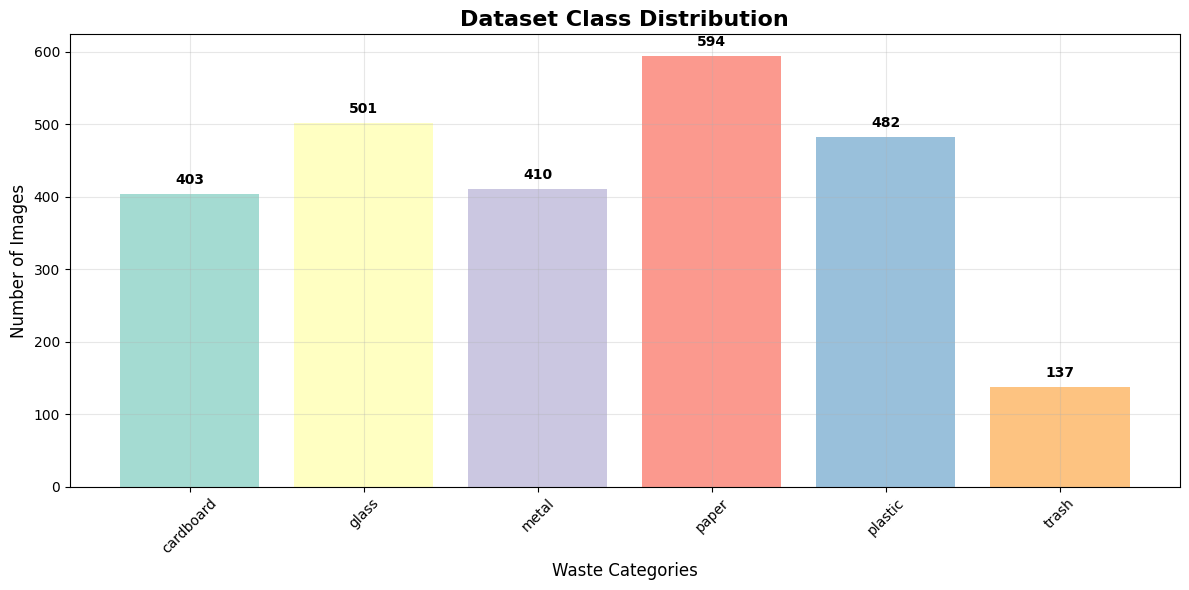


📊 Dataset Statistics:
Class        Count    Percentage
-----------------------------------
cardboard    403        15.9%
glass        501        19.8%
metal        410        16.2%
paper        594        23.5%
plastic      482        19.1%
trash        137         5.4%
-----------------------------------
Total        2527     100.0%

📂 Creating optimized data loaders...
Loading full samples...
✅ Loaded 2527 samples for full

Full class distribution:
   cardboard:  403 ( 15.9%)
       glass:  501 ( 19.8%)
       metal:  410 ( 16.2%)
       paper:  594 ( 23.5%)
     plastic:  482 ( 19.1%)
       trash:  137 (  5.4%)

📊 Data Loader Summary:
  Training samples:     1768
  Validation samples:    506
  Test samples:          253
  Batch size:             32
🏷️ Class weights: [1.045 0.841 1.027 0.709 0.874 3.074]
Setting up model...
Loading pretrained backbones...
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1

100%|██████████| 77.4M/77.4M [00:00<00:00, 165MB/s]


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 166MB/s]

✅ RWC-Net initialized with 28,151,394 parameters


✅ Model setup complete on cuda

🏃‍♂️ Starting complete training...

🚀 Starting Training on cuda

📅 Epoch 1/30


📈 Train: Loss=2.6205, Acc=49.26%
📉 Val:   Loss=1.2362, Acc=78.85%
⏰ Time: 499.6s, LR: 1.00e-04
🎉 New best model! Val Acc: 78.85%

📅 Epoch 2/30


📈 Train: Loss=1.2315, Acc=76.65%
📉 Val:   Loss=0.7926, Acc=86.17%
⏰ Time: 30.8s, LR: 1.00e-04
🎉 New best model! Val Acc: 86.17%

📅 Epoch 3/30


📈 Train: Loss=0.7148, Acc=87.73%
📉 Val:   Loss=0.6691, Acc=86.96%
⏰ Time: 29.0s, LR: 1.00e-04
🎉 New best model! Val Acc: 86.96%

📅 Epoch 4/30


📈 Train: Loss=0.5134, Acc=91.88%
📉 Val:   Loss=0.6075, Acc=88.14%
⏰ Time: 28.6s, LR: 1.00e-04
🎉 New best model! Val Acc: 88.14%

📅 Epoch 5/30


📈 Train: Loss=0.3594, Acc=94.09%
📉 Val:   Loss=0.5147, Acc=91.50%
⏰ Time: 28.8s, LR: 1.00e-04
🎉 New best model! Val Acc: 91.50%

📅 Epoch 6/30


📈 Train: Loss=0.2429, Acc=96.88%
📉 Val:   Loss=0.5283, Acc=91.11%
⏰ Time: 28.9s, LR: 1.00e-04

📅 Epoch 7/30


📈 Train: Loss=0.1785, Acc=97.95%
📉 Val:   Loss=0.4863, Acc=91.90%
⏰ Time: 30.9s, LR: 1.00e-04
🎉 New best model! Val Acc: 91.90%

📅 Epoch 8/30


📈 Train: Loss=0.1504, Acc=98.47%
📉 Val:   Loss=0.5076, Acc=91.11%
⏰ Time: 29.4s, LR: 1.00e-04

📅 Epoch 9/30


📈 Train: Loss=0.1152, Acc=98.86%
📉 Val:   Loss=0.5036, Acc=91.30%
⏰ Time: 28.9s, LR: 1.00e-04

📅 Epoch 10/30


📈 Train: Loss=0.1151, Acc=99.09%
📉 Val:   Loss=0.5925, Acc=89.92%
⏰ Time: 29.3s, LR: 5.00e-05

📅 Epoch 11/30


📈 Train: Loss=0.0875, Acc=98.98%
📉 Val:   Loss=0.4679, Acc=91.11%
⏰ Time: 29.2s, LR: 5.00e-05

📅 Epoch 12/30


📈 Train: Loss=0.0803, Acc=99.38%
📉 Val:   Loss=0.5015, Acc=90.91%
⏰ Time: 29.5s, LR: 5.00e-05

📅 Epoch 13/30


📈 Train: Loss=0.0745, Acc=99.20%
📉 Val:   Loss=0.4874, Acc=91.50%
⏰ Time: 30.3s, LR: 5.00e-05

📅 Epoch 14/30


📈 Train: Loss=0.0639, Acc=99.49%
📉 Val:   Loss=0.4909, Acc=91.70%
⏰ Time: 27.8s, LR: 5.00e-05

📅 Epoch 15/30


📈 Train: Loss=0.0559, Acc=99.38%
📉 Val:   Loss=0.4858, Acc=91.70%
⏰ Time: 28.1s, LR: 5.00e-05
⏹️ Early stopping triggered after 15 epochs
✅ Loaded best model with validation accuracy: 91.90%

🏁 Training completed in 15.17 minutes

🧪 Comprehensive evaluation...
🔍 Evaluating model...


Evaluating: 100%|██████████| 8/8 [00:57<00:00,  7.24s/it]


✅ Evaluation completed!

📈 Training History:


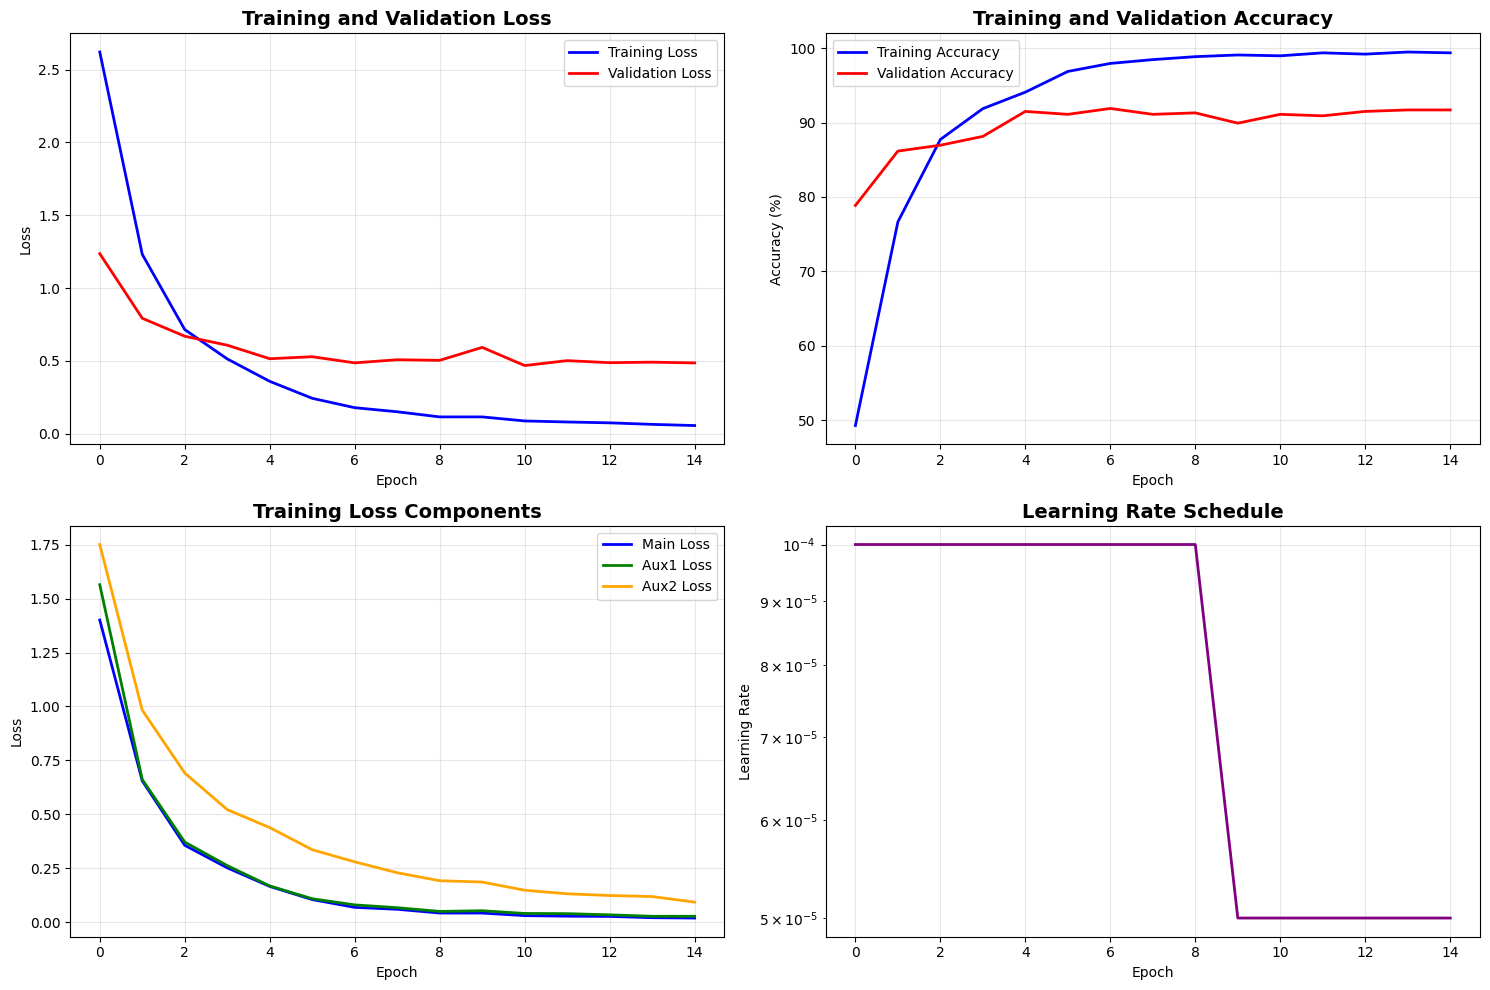


📊 Test Set Evaluation:

📊 MODEL EVALUATION METRICS
Accuracy                 : 0.9565
Precision (Macro)        : 0.9604
Precision (Weighted)     : 0.9603
Recall (Macro)           : 0.9639
Recall (Weighted)        : 0.9565
F1-Score (Macro)         : 0.9608
F1-Score (Weighted)      : 0.9570
ROC AUC (Macro)          : 0.9981

------------------------------------------------------------
📈 PER-CLASS METRICS
------------------------------------------------------------
Class        Precision  Recall     F1-Score   ROC AUC   
------------------------------------------------------------
cardboard    0.9512     0.9750     0.9630     0.9995    
glass        0.9783     0.9000     0.9375     0.9951    
metal        0.8542     1.0000     0.9213     0.9967    
paper        1.0000     0.9500     0.9744     0.9998    
plastic      0.9787     0.9583     0.9684     0.9974    
trash        1.0000     1.0000     1.0000     1.0000    


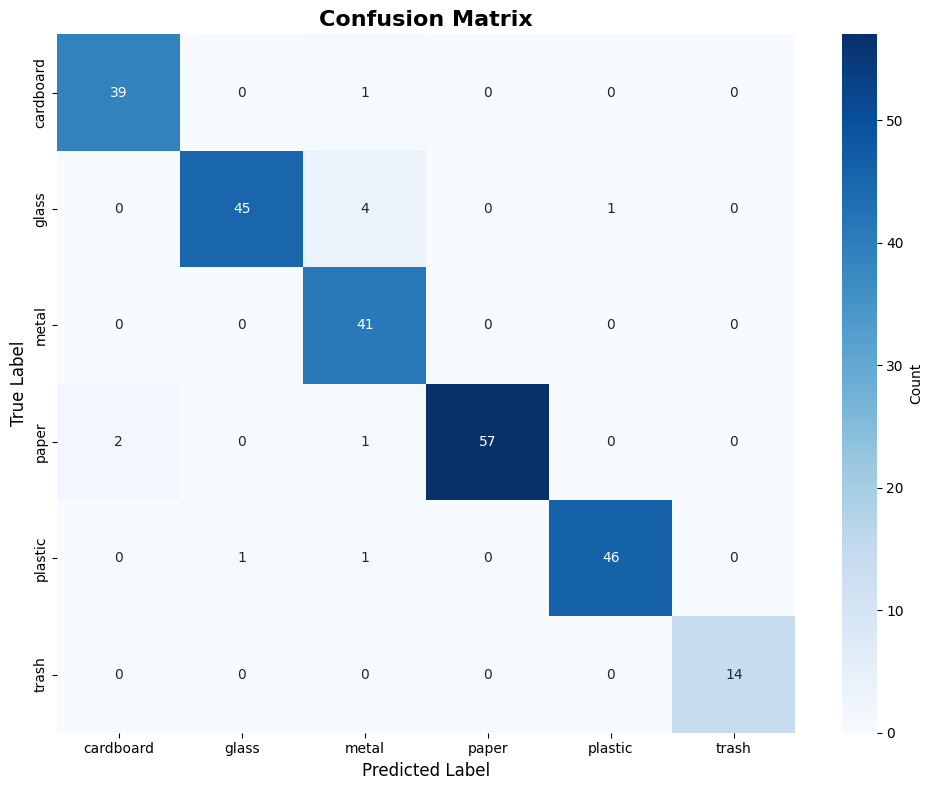


📋 Normalized Confusion Matrix:
--------------------------------------------------
                Pred_cardboard  Pred_glass  Pred_metal  Pred_paper  Pred_plastic  Pred_trash
True_cardboard           0.975       0.000       0.025        0.00         0.000         0.0
True_glass               0.000       0.900       0.080        0.00         0.020         0.0
True_metal               0.000       0.000       1.000        0.00         0.000         0.0
True_paper               0.033       0.000       0.017        0.95         0.000         0.0
True_plastic             0.000       0.021       0.021        0.00         0.958         0.0
True_trash               0.000       0.000       0.000        0.00         0.000         1.0


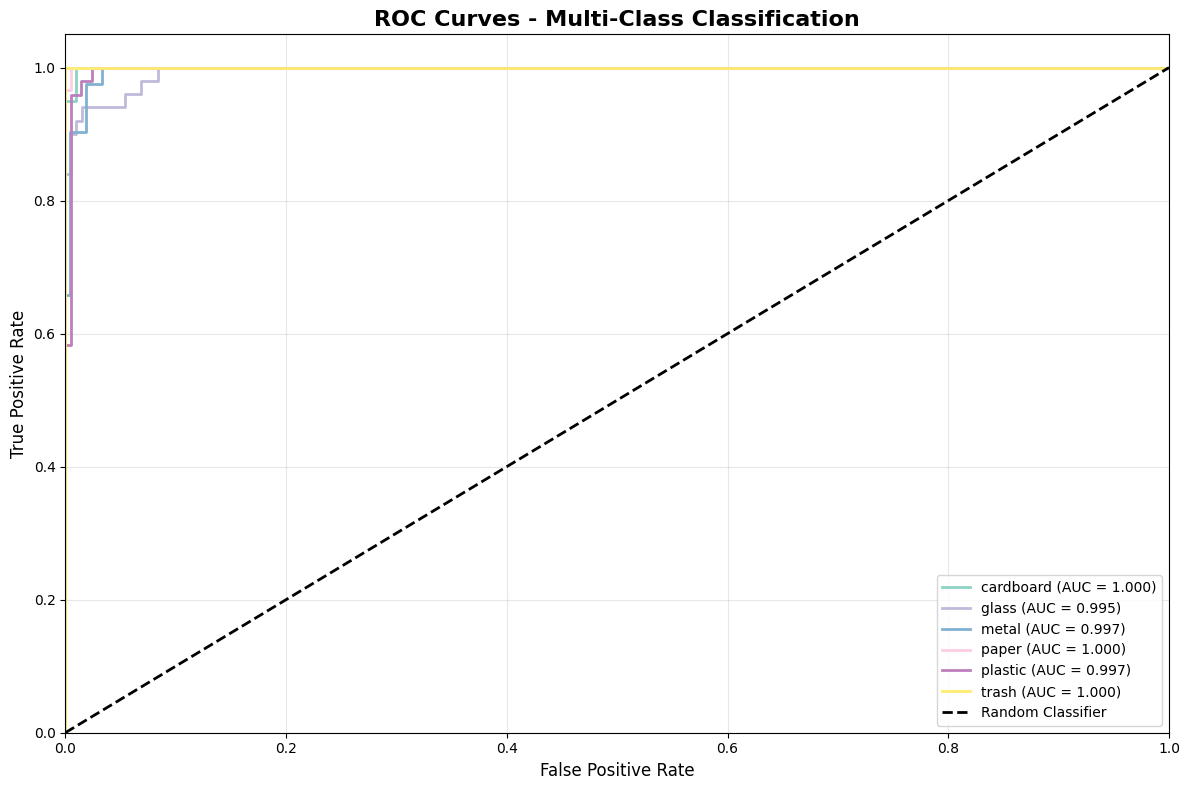

🔍 Found 11 misclassified samples
📈 Error Rate by Class:
   cardboard: 0.025 (1/40)
       glass: 0.100 (5/50)
       metal: 0.000 (0/41)
       paper: 0.050 (3/60)
     plastic: 0.042 (2/48)
       trash: 0.000 (0/14)

🔍 Sample Predictions:


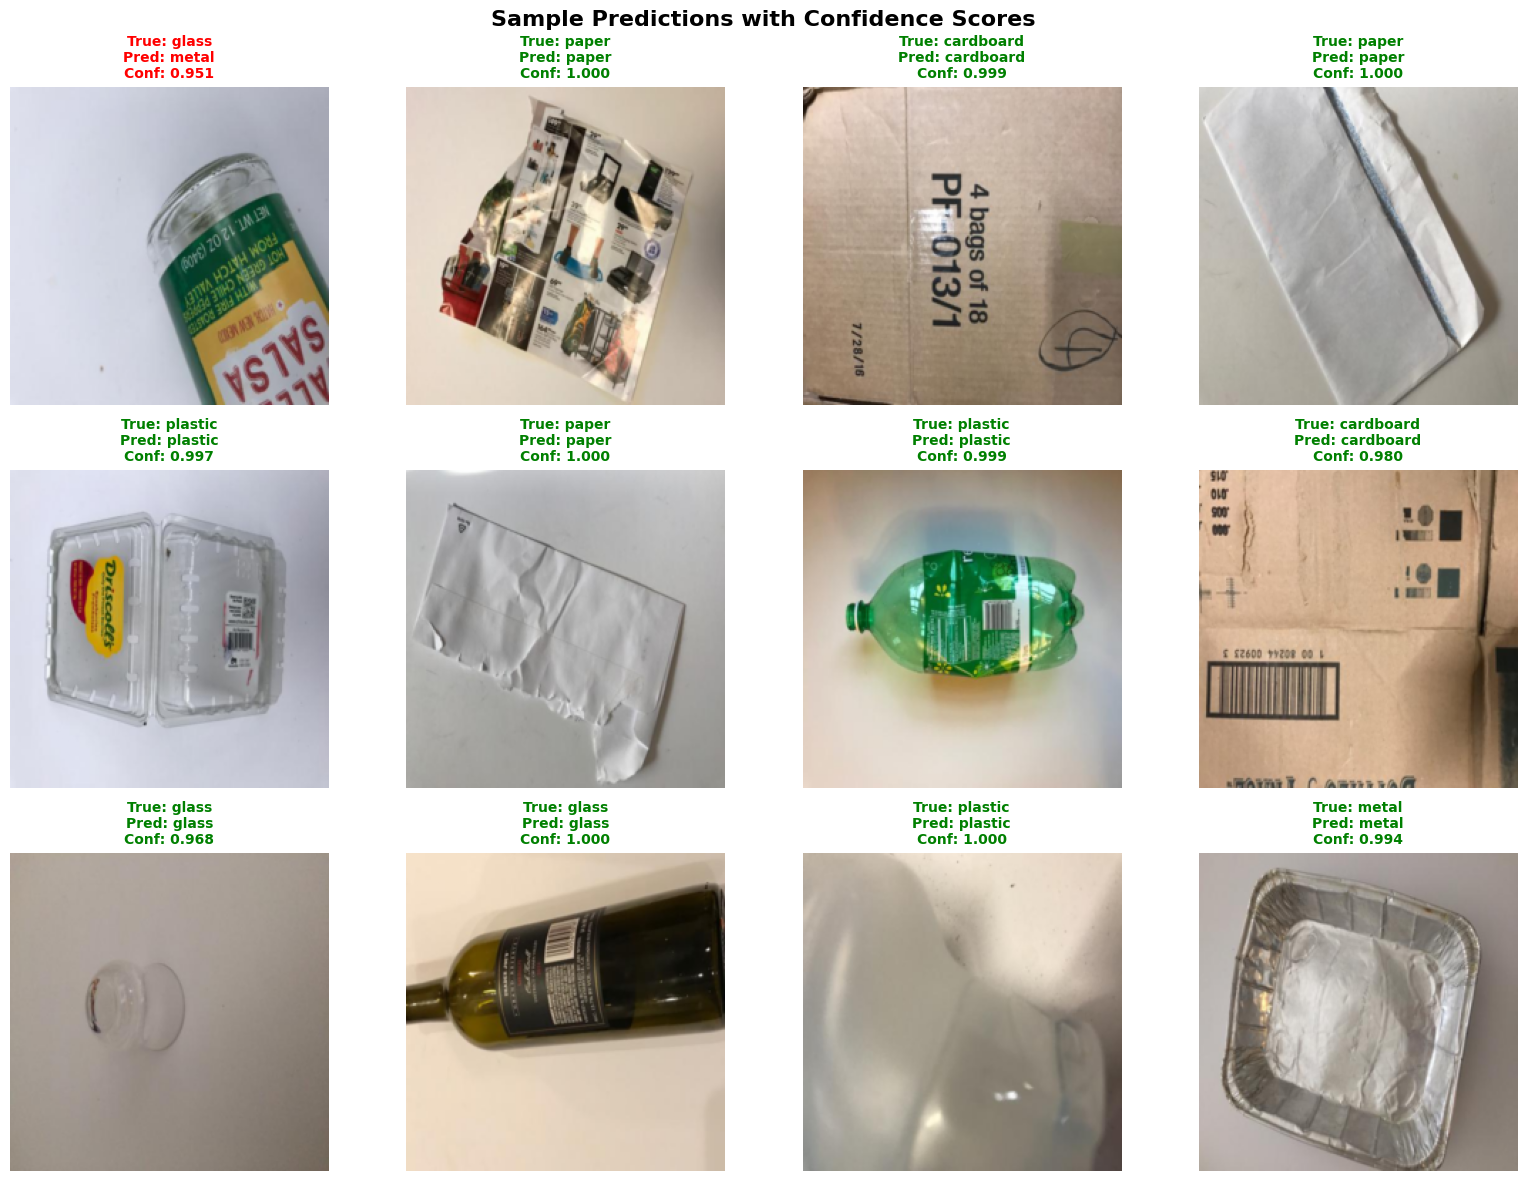


💾 Saving complete trained model...
✅ Complete model saved to: /content/rwc_net_complete_model.pth

🎉 TRAINING COMPLETE!
📊 Final Results:
  Best Validation Accuracy: 91.90%
  Test Accuracy: 95.65%
  Test F1-Score (Macro): 0.9608
  Test ROC AUC (Macro): 0.9981

✅ Complete training finished! Test Accuracy: 95.65%


In [18]:
# 1. 🚀 COMPLETE TRAINING
results = main('complete')

In [19]:
# 2. QUICK TEST (5 epochs - for testing)
# results = main('quick', quick_epochs=5)

# 3. DEMO MODE (3 epochs - for demonstration)
# results = main('demo')

# 4. ANALYZE DATASET ONLY
# results = main('analyze')

# 5. CUSTOM TRAINING (specify your own parameters)
# results = main('quick', dataset_path=DRIVE_DATASET_PATH, quick_epochs=10)
# uncomment as per usage